In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload
from enum import Enum
from time import time
from pathlib import Path

# Third-Party Library Imports
import numpy as np
import xarray as xr
import dask
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import my_stats
import toe_calc
import open_data
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")
warnings.filterwarnings("ignore")

Matplotlib created a temporary cache directory at /jobfs/136071117.gadi-pbs/matplotlib-8md45k4i because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [4]:
%config Application.verbose_crash=True

In [5]:
xr.set_options(display_expand_data=False)

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [7]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [8]:
# client.close()

In [9]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=104, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/136071117.gadi-pbs/dask-scratch-space/scheduler-1haqhp8o', purging
 -   Scheduler at:     tcp://127.0.0.1:45593
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:35933'
 -         Start Nanny at: 'tcp://127.0.0.1:45491'
 -         Start Nanny at: 'tcp://127.0.0.1:33747'
 -         Start Nanny at: 'tcp://127.0.0.1:42505'
 -         Start Nanny at: 'tcp://127.0.0.1:40849'
 -         Start Nanny at: 'tcp://127.0.0.1:42227'
 -         Start Nanny at: 'tcp://127.0.0.1:46347'
 -         Start Nanny at: 'tcp://127.0.0.1:40453'
 -         Start Nanny at: 'tcp://127.0.0.1:39479'
 -         Start Nanny at: 'tcp://127.0.0.1:41307'
 -         Start Nanny at: 'tcp://127.0.0.1:39721'
 -         Start Nanny at: 'tcp://127.0.0.1:42159'
 -         Start Nanny at: 'tcp://127.0.0.1:45231'
 -         Start Nanny at: 'tcp://127.0.0.1:45565'
 -         Start Nanny at: 't

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 104
Total threads: 104,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45593,Workers: 104
Dashboard: /proxy/8787/status,Total threads: 104
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43209,Total threads: 1
Dashboard: /proxy/39963/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35933,


 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long

In [10]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [11]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_(1930_1960)',
       'best_tas_(1940_1970)', 'cesm1_lens_rcp85_tas_(1920_1950)',
       'cesm1_lens_rcp85_tas_multi_base_period.zarr', 'era5', 'old',
       'to_delete'], dtype='<U43')

In [15]:
variable = 'tas'

model  =  'best'

# experiment = 'rcp85'
# model = 'cesm1_lens'
dataset_name = model#f'{model}_{experiment}'

In [16]:
SAVE_NAME = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_multi_base_period.zarr')
SAVE_NAME                         

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_multi_base_period.zarr'

In [17]:
chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//8, 'lat':72//12}

chunks = chunks_best_small#LE_CESM_CHUNKS

In [18]:
# If no ensemble
plot_kwargs = {} 
ensemble_kwargs = {}

# If ensemble
# plot_kwargs = {'hue':'member', 'add_legend':False} 
# ensemble_kwargs = {'member': 0}

<h2 style='color:cyan'> Opening Data </h2>

In [22]:
data_raw_ds = open_data.open_best(chunks_best_small).persist()
wait(data_raw_ds);

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [23]:
# FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'
# FILE_NAME

In [20]:
# data_raw_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=LE_CESM_CHUNKS)['tas']
# data_raw_ds = data_raw_ds.sel(time=data_raw_ds.time.dt.year>1920)

In [24]:
data_raw_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)> Size: 45MB
dask.array<xarray-<this-array>, shape=(175, 180, 360), dtype=float32, chunksize=(175, 18, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [29]:
# Tranpose time to be last dimension to make transpose easier 
data_raw_ds = data_raw_ds.transpose(..., "time").persist()
wait(data_raw_ds);

In [30]:
data_raw_ds.chunks

((18, 18, 18, 18, 18, 18, 18, 18, 18, 18),
 (36, 36, 36, 36, 36, 36, 36, 36, 36, 36),
 (175,))

In [31]:
# data_raw_ds = data_raw_ds.isel(member=slice(0,3))

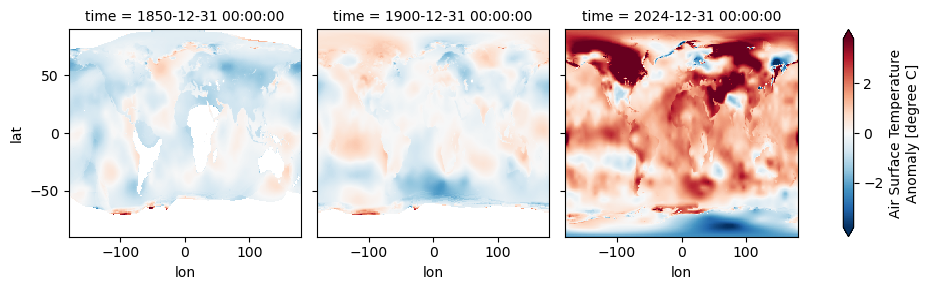

In [35]:
data_raw_ds.isel(time=[0, 50, -1]).isel(**ensemble_kwargs).plot(col='time', robust=True)

In [37]:
data_raw_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 175)> Size: 45MB
dask.array<transpose, shape=(180, 360, 175), dtype=float32, chunksize=(18, 36, 175), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

<h1 style='color:yellow'>  Calculations</h1>

In [38]:
def fga(data_ds, base_period_ds, data_ds_window):
    # The x-values for the KDE are based upon the max and min
    data_max = data_ds.max().persist().values.item()
    data_min = data_ds.min().persist().values.item()
    num_points = 1000
    x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)
    
    
    kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
    
    base_period_kde = xr.apply_ufunc(
        toe_calc.create_kde_x_exists,
        base_period_ds,
        input_core_dims=[['time'], ],
        output_core_dims=[['x']],
        kwargs={'x': x, **kde_kwargs},
        vectorize=True,
        dask='parallelized',
        output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
        output_dtypes=float
    ).persist()
    wait(base_period_kde);
    
    frac_geom_ds = xr.apply_ufunc(
        toe_calc.fractional_geometric_area_optimized,
        data_ds_window,
        base_period_kde,
        input_core_dims=[['window_dim'], ['x']],
        exclude_dims={'window_dim'},
        kwargs={'x': x, 'method_kwargs':kde_kwargs},
        vectorize=True,
        dask='parallelized',
        output_dtypes=float
    ).compute()
    # wait(frac_geom_ds2)
    
    x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
    frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}

    frac_geom_ds.name = 'frac'
    
    return frac_geom_ds

In [39]:
def ks(data_ds_window, base_period_window_ds):
    # The arguements needed for all of the calculations
    rolling_window_kwargs = dict(
        input_core_dims=[['window_dim'], ['window_dim']],
        exclude_dims={'window_dim'},
        vectorize=True,
        dask='parallelized')
    
    ks_ds = xr.apply_ufunc(
            toe_calc.return_ks_pvalue,
            data_ds_window,
            base_period_window_ds,
        **rolling_window_kwargs
        ).compute()

    ks_ds.name = 'ks'
    return ks_ds

In [40]:
def sn_ratio(data_ds, base_period_ds, base_period):

    # Resetting the anomlies to 1850
    data_anom_ds = data_ds - base_period_ds.mean(dim='time')
    base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')
    
    ds_signal_lowess = xr.apply_ufunc(
        my_stats.apply_lowess, 
        data_anom_ds.chunk({'time':-1, 'lat':10}), 
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True, 
        kwargs = dict(window=41),
        dask='parallelized',
        output_dtypes=[float]
    ).compute()
    
    # Noise series is detrended data
    ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
    
    ds_noise_lowess_base_period = ds_noise_series_lowess.sel(
        time=slice(str(base_period.start), str(base_period.end))).std(dim='time')
        
    # S/N 
    ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period
    ds_sn_lowess_base_period.name = 'sn'

    return ds_sn_lowess_base_period

In [46]:
window = 30
CHUNKS_FOR_PVALUE_TESTS = chunks

In [47]:
# raw_data_ds = raw_data_ds.sel(lat=slice(0, 10), lon=slice(110, 120))

In [48]:
data_raw_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 175)> Size: 45MB
dask.array<transpose, shape=(180, 360, 175), dtype=float32, chunksize=(18, 36, 175), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [89]:
SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_multi_base_period.zarr'

In [78]:
# Check if file already exists
# If it does, check what base_period is has already been saved with
if Path(SAVE_NAME).exists():
    print('File already exists')
    with xr.open_zarr(SAVE_NAME) as ds:
        save_based_periods = np.array(ds.base_period.values)
else:
    print('File does not exist yet')
    save_based_periods = []#['-9999'] # Default fill to stop erros

File already exists


In [82]:
save_based_periods_start = list(map(lambda x: int(x.split('_')[0]), save_based_periods))
save_based_periods_start

[1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980]

In [76]:
base_period_starts = np.sort(list(map(lambda x: int(x.split('_')[0]), save_based_periods)))
base_period_starts

array([1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970,
       1975, 1980])

In [75]:
# all_base_periods = np.arange(1920, 2055, 5)
all_base_periods = np.arange(1850, 1980, 5)
all_base_periods

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955,
       1960, 1965, 1970, 1975])

In [84]:
base_periods_to_run = np.array([bp for bp in all_base_periods if bp not in save_based_periods_start])
base_periods_to_run

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915])

In [85]:
# base_periods_to_run = all_base_periods[all_base_periods>largest_base_period]
# base_periods_to_run

In [86]:
base_periods_to_run.shape

(14,)

In [87]:
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="ks_2samp: Exact calculation unsuccessful")

In [88]:
for i, base_period_start in enumerate(base_periods_to_run):
    t_start = time()
    print(f'{base_period_start}, ', end='')
    
    data_ds = data_raw_ds.copy()
    data_ds = data_ds.sel(time=data_ds.time.dt.year>base_period_start)
    
    base_period_obj = toe_const.BasePeriod(base_period_start, base_period_start+30)
    
    base_period_ds = data_ds.sel(
        time=slice(str(base_period_obj.start), str(base_period_obj.end)))

    
    base_period_ds_count = base_period_ds.count(dim='time')
    percent_80_of_years = 0.8*(base_period_obj.end - base_period_obj.start)

    data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
    
    data_ds = data_ds.where(data_availability_mask)
    base_period_ds = base_period_ds.where(data_availability_mask)


    
    data_ds_window = (
        data_ds
        .rolling(time=window, center=True, min_periods=window)
        .construct('window_dim')
        .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
        .persist()
    ) 
    
    base_period_window_ds = (
        data_ds.sel(time=slice(str(base_period_obj.start), str(base_period_obj.end)))
        .chunk(CHUNKS_FOR_PVALUE_TESTS)
        .rename({'time':'window_dim'})
        .persist()
    )

    wait(data_ds_window);
    wait(base_period_window_ds);
    
    sn_ds = sn_ratio(data_ds, base_period_ds, base_period_obj)
    print('.', end='')
    ks_ds = ks(data_ds_window, base_period_window_ds)
    print('.', end='')
    fga_ds = fga(data_ds, base_period_ds, data_ds_window)
    print('.', end='')

    out_ds = xr.merge([sn_ds, ks_ds, fga_ds])
    out_ds = out_ds.expand_dims('base_period').assign_coords(
        base_period=[f'{base_period_obj.start}_{base_period_obj.end}'])
    # Length of time needs to match - pad with nans
    out_ds = out_ds.reindex(time=data_raw_ds.time, fill_value=np.nan)

    if not Path(SAVE_NAME).exists():
        print(' - creaing new file - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='w')
    else:
        print(f' - appending {base_period_obj.start}_{base_period_obj.end} to baese_period dim - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')
        
    time_taken = (time() - t_start)/60
    print(f' ({time_taken:.2f})')

1850, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1850_1880 to baese_period dim -  (1.82)
1855, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1855_1885 to baese_period dim -  (1.85)
1860, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1860_1890 to baese_period dim -  (1.77)
1865, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1865_1895 to baese_period dim -  (1.74)
1870, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1870_1900 to baese_period dim -  (1.72)
1875, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1875_1905 to baese_period dim -  (1.63)
1880, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1880_1910 to baese_period dim -  (1.62)
1885, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1885_1915 to baese_period dim -  (1.57)
1890, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1890_1920 to baese_period dim -  (1.52)
1895, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1895_1925 to baese_period dim -  (1.43)
1900, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1900_1930 to baese_period dim -  (1.40)
1905, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1905_1935 to baese_period dim -  (1.32)
1910, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1910_1940 to baese_period dim -  (1.32)
1915, .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


.. - appending 1915_1945 to baese_period dim -  (1.23)


In [95]:
# out_ds_2 = out_ds.copy(deep=True)

In [96]:
# Pad new out_ds to match max_time_len
# out_ds_2 = out_ds_2.reindex(time=data_raw_ds.time, fill_value=np.nan)

In [104]:
# Now append safely
# out_ds_2.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')

In [50]:
# base_period_ds = xr.concat(base_period_stor, dim='base_period')

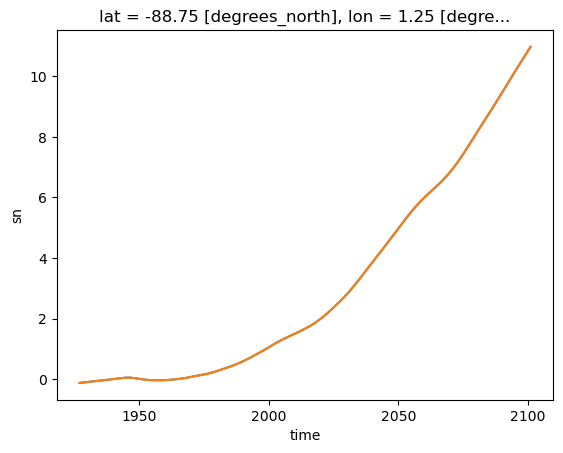

In [103]:
out_ds.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);
out_ds_2.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);

In [ ]:
# base_period_ds.to_zarr(SAVE_NAME, mode='w')